# Анализ данных о поездках на такси в Нью-Йорке за май 2016 года

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

Опишем вспомогательные классы для представления точек и прямоугольников на карте

In [2]:
class Point:
    def __init__(self, longitude, latitude):
        self.longitude = longitude
        self.latitude = latitude
        
    def __add__(self, other):
        return Point(self.longitude + other.longitude, self.latitude + other.latitude)
    
    def __str__(self):
        return str(str(self.longitude) + ", " + str(self.latitude))

class Rectangle:
    def __init__(self, upper_left_pnt, lower_right_pnt):
        self.left_pnt = upper_left_pnt
        self.right_pnt = lower_right_pnt
    def within(self, point):
        left = (point.longitude >= self.left_pnt.longitude) & (point.latitude <= self.left_pnt.latitude)
        right = (point.longitude <= self.right_pnt.longitude) & (point.latitude >= self.right_pnt.latitude)
        return left & right
    def __str__(self):
        return '{} {}'.format(self.left_pnt, self.right_pnt)

долгота - longitude - x

широта - latitude - y

Прямоугольник, которым окружен Нью-Йорк

In [3]:
ny_rect = Rectangle(Point(-74.25559, 40.91553), Point(-73.70001, 40.49612))

Считаем данные за май 2016 года. Считаем только необходимые для анализа столбцы

In [4]:
%%time
data = pd.read_csv("D:/Course 6 data/yellow_tripdata_2016-05.csv", usecols=[
        "tpep_pickup_datetime", "tpep_dropoff_datetime", 
        "passenger_count", "trip_distance", "pickup_longitude",
        "pickup_latitude", "dropoff_longitude", "dropoff_latitude"])
print data.shape

(11836853, 8)
Wall time: 23.4 s


Удалим некорректные данные:
* поездки с 0 количеством пассажиров
* поездки с нулевой длительностью
* поездки с нулевым расстоянием
* и поездки, начинающиеся за пределами Нью-Йорка

In [5]:
%%time
to_drop = [
    'data["passenger_count"] == 0',
    'data["tpep_pickup_datetime"] == data["tpep_dropoff_datetime"]',
    'data["trip_distance"] == 0.0',
    'ny_rect.within(Point(data.pickup_longitude, data.pickup_latitude)) == False'
]
                                                                                                 
print data.shape
for condition in to_drop:
    data.drop(data.index[eval(condition)], inplace=True)
print data.shape

(11836853, 8)
(11626521, 8)
Wall time: 6.2 s


Удалим минуты и секунды у даты начала и даты конца поездки

In [6]:
%%time
data["pickup_datetime"] = [datetime.strptime(x[:-6], '%Y-%m-%d %H') for x in data["tpep_pickup_datetime"]]
data["dropoff_datetime"] = [datetime.strptime(x[:-6], '%Y-%m-%d %H') for x in data["tpep_dropoff_datetime"]]
data.drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1, inplace=True)

Wall time: 3min 28s


In [7]:
data.shape

(11626521, 8)

Считаем идентификаторы областей (не боро) Нью-Йорка

In [8]:
regions = pd.read_csv("regions.csv", sep=";", index_col="region")

In [9]:
def getPntsFromRegion(x, y, id):
    a = regions.west[id]
    b = regions.east[id]
    c = regions.north[id]
    d = regions.south[id]
    return (x >= a) & (x <= b) & (y >= d) & (y <= c)

In [10]:
def getRegionID(point):
    a = regions.west <= point.longitude
    b = regions.east >= point.longitude
    c = regions.north >= point.latitude
    d = regions.south <= point.latitude
    return regions[a & b & c & d].index[0]

Для каждой области будем искать точки отправления, находящиеся в этой области. По сути выполняется фильтрация исходного набора данных по координатам отправления. Фильтрация оказалась быстрее других подходов. Буду рад, предложениям как ускорить :)

И выведем первые несколько строк получившегося набора данных

In [11]:
%%time
data["pickup_region_id"] = np.zeros(data.shape[0], dtype=int)
for i in xrange(1, 2501):
    data.ix[getPntsFromRegion(data.pickup_longitude, data.pickup_latitude, i), ["pickup_region_id"]] = i
print data.head()

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           3.60        -73.985901        40.768040   
1                1           1.68        -73.991577        40.744751   
2                6           1.09        -73.993073        40.741573   
3                1           4.21        -73.991943        40.684601   
4                1           0.56        -74.005280        40.740192   

   dropoff_longitude  dropoff_latitude pickup_datetime dropoff_datetime  \
0         -73.983986         40.730099      2016-05-01       2016-05-01   
1         -73.975700         40.765469      2016-05-01       2016-05-01   
2         -73.980995         40.744633      2016-05-01       2016-05-01   
3         -74.002258         40.733002      2016-05-01       2016-05-01   
4         -73.997498         40.737564      2016-05-01       2016-05-01   

   pickup_region_id  
0              1233  
1              1180  
2              1180  
3              1173  
4     

Агрегируем данные по областям и часам. Для этого переведем все даты начала поездки в количество часов с 1 мая 2016 года. 744 это суммарное количество часов за месяц.

In [12]:
begin_date = datetime(year=2016, month=5, day=1)
data["hours_from_begin"] = [int((x - begin_date).total_seconds() / 3600) for x in data["pickup_datetime"]]

In [13]:
table = stats.binned_statistic_2d(data.pickup_region_id, data.hours_from_begin, None, 'count', 
                                  bins=[range(1, 2502), range(745)])

In [14]:
hist_header = [begin_date + timedelta(hours=x) for x in range(744)]
histogram = pd.DataFrame(data=table.statistic, columns=hist_header, index=range(1, 2501))

И выводим первые несколько строк. В этой части таблицы много пустых значений. Если посмотреть на карту Нью-Йорка, то все становится понятно - данная часть прямоугольника, описывающая Нью-Йорк, не относится к Нью-Йорку и соответсвенно в выборку не попала. Также присутствуют точки, в которых в принципе нельзя вызвать такси - парки и река.

In [15]:
print histogram.head()

   2016-05-01 00:00:00  2016-05-01 01:00:00  2016-05-01 02:00:00  \
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   
5                  0.0                  0.0                  0.0   

   2016-05-01 03:00:00  2016-05-01 04:00:00  2016-05-01 05:00:00  \
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   
5                  0.0                  0.0                  0.0   

   2016-05-01 06:00:00  2016-05-01 07:00:00  2016-05-01 08:00:00  \
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0   

Вводим координаты Эмпайр-стейт-билдинг и получаем соответствующий ему номер области.

In [16]:
empire_state_building = Point(-73.985661, 40.748450)

In [17]:
region_id_empire_state = getRegionID(empire_state_building)
print region_id_empire_state

1231


Теперь выводим данные о количестве поездок в любое время из этой области. Так же рисуем график.

In [18]:
pick_up_times = histogram.iloc[region_id_empire_state - 1, :]
print histogram.index[region_id_empire_state - 1] # номер региона совпадает, значит все верно
print pick_up_times

1231
2016-05-01 00:00:00     881.0
2016-05-01 01:00:00     713.0
2016-05-01 02:00:00     533.0
2016-05-01 03:00:00     418.0
2016-05-01 04:00:00     353.0
2016-05-01 05:00:00     151.0
2016-05-01 06:00:00     147.0
2016-05-01 07:00:00     158.0
2016-05-01 08:00:00     256.0
2016-05-01 09:00:00     340.0
2016-05-01 10:00:00     563.0
2016-05-01 11:00:00     756.0
2016-05-01 12:00:00     819.0
2016-05-01 13:00:00     756.0
2016-05-01 14:00:00     766.0
2016-05-01 15:00:00     801.0
2016-05-01 16:00:00     779.0
2016-05-01 17:00:00     822.0
2016-05-01 18:00:00     926.0
2016-05-01 19:00:00     820.0
2016-05-01 20:00:00     698.0
2016-05-01 21:00:00     565.0
2016-05-01 22:00:00     394.0
2016-05-01 23:00:00     436.0
2016-05-02 00:00:00     266.0
2016-05-02 01:00:00     129.0
2016-05-02 02:00:00      86.0
2016-05-02 03:00:00      50.0
2016-05-02 04:00:00      92.0
2016-05-02 05:00:00     126.0
                        ...  
2016-05-30 18:00:00     816.0
2016-05-30 19:00:00     772.0
2016-

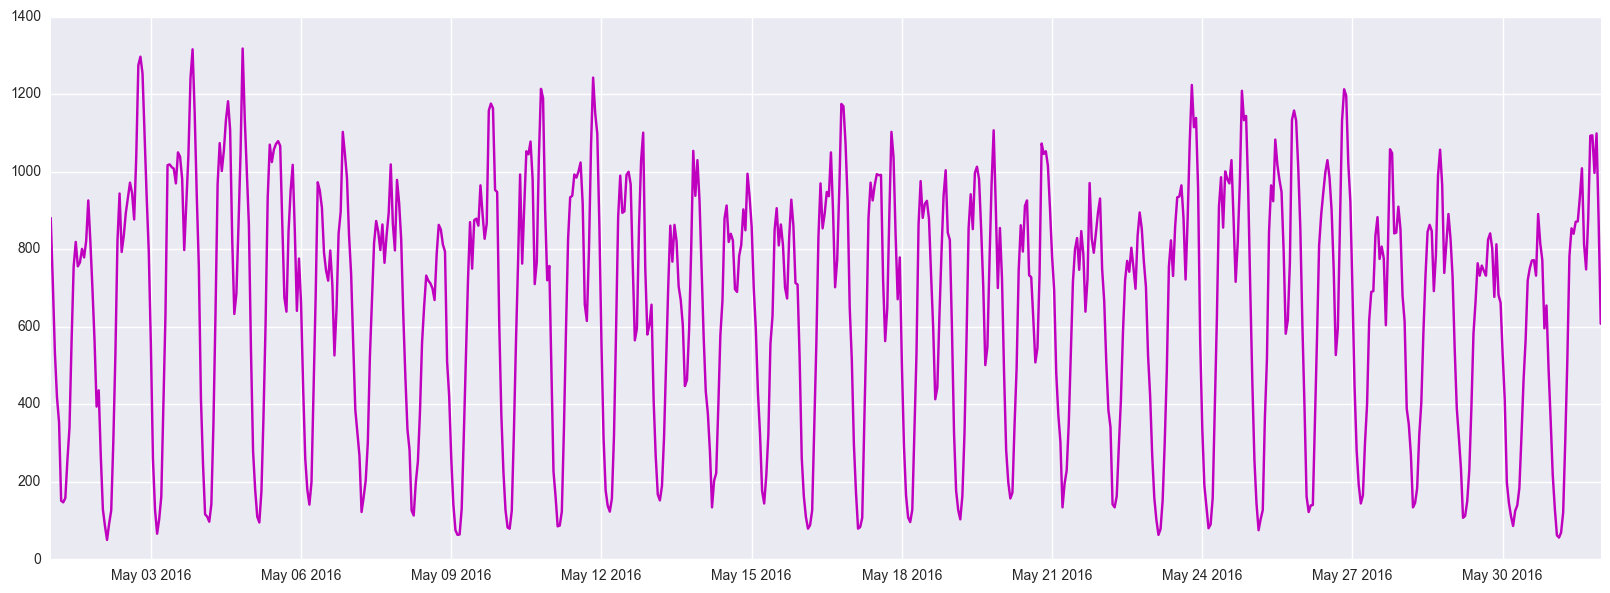

In [19]:
plt.figure(figsize=(20, 7))
plt.plot(pick_up_times, 'm-')

In [20]:
count = histogram.shape[0] * histogram.shape[1] - np.count_nonzero(histogram)
print "В " + str(count) + " из " + str(histogram.shape[0] * histogram.shape[1]) + " ячейках не было совершенно ни одной поездки"

В 1718238 из 1860000 ячейках не было совершенно ни одной поездки


In [21]:
histogram.to_csv("yellow_tripdata_aggregated_2016-05.csv", index_label="region_id")